# 0. Import libraries and load Data

In [1]:
!pip install pandas -q
!pip install numpy -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install scikit-learn -q
!pip install scipy -q
!pip install feature_engine -q
!pip install pgeocode -q
!pip install tqdm -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import math
import seaborn as sns
import pgeocode
from tqdm import tqdm

In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
poi_df = pd.read_csv('data/poi.csv')

/tmp/ipykernel_9252/4245473066.py:3: DtypeWarning: Columns (7,9,11,13,17,18,19,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,74,77,80,82,83,84,85,86,87,90,91,92,95) have mixed types. Specify dtype option on import or set low_memory=False.
  poi_df = pd.read_csv('data/poi.csv')


# 1. Data Preparing

# 1.1. Point of Interest Analysis

In [4]:
poi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397382 entries, 0 to 397381
Data columns (total 96 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id_on_platform         397382 non-null  int64  
 1   lat                    397382 non-null  float64
 2   lon                    397382 non-null  float64
 3   source                 397382 non-null  object 
 4   tags.addr:city         80929 non-null   object 
 5   tags.addr:country      32852 non-null   object 
 6   tags.addr:housenumber  104548 non-null  object 
 7   tags.addr:postcode     64669 non-null   object 
 8   tags.addr:street       97486 non-null   object 
 9   tags.alt_name:gl       1 non-null       object 
 10  tags.amenity           50459 non-null   object 
 11  tags.artwork_type      662 non-null     object 
 12  tags.barrier           42890 non-null   object 
 13  tags.bicycle           3878 non-null    object 
 14  tags.brand             4342 non-null

In [5]:
poi_df = poi_df.filter(['lat', 'lon', 'tags.addr:postcode', 'tags.addr:country']).rename(columns={'tags.addr:postcode':'postcode', 'tags.addr:country':'country'})

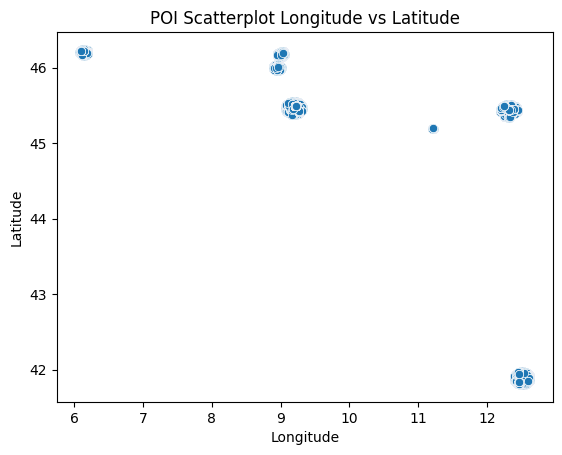

In [6]:
sns.scatterplot(x='lon', y='lat', data=poi_df)
plt.title('POI Scatterplot Longitude vs Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

# 1.2. Train Dataset Analysis

In [7]:
# drop id
train_df.drop('id', axis=1, inplace=True)

# 1.3. Add Features

In [19]:
def get_poi_features(lat, lon, poi_df, radius=0.001):
    country, city_lat, city_lon, n_poi, postcode = np.nan, np.nan, np.nan, np.nan, np.nan
    if math.isnan(lat) or math.isnan(lon):
        return country, city_lat, city_lon, n_poi, postcode
    # radius = 0.03 -> 3km
    # get all poi in a certain radius from the current lat and lon
    series = poi_df[(poi_df['lat']-lat)**2 + (poi_df['lon']-lon)**2 <= radius**2]
    # n_poi = np.nan if series.shape[0] == 0 else series.shape[0]
    if series.shape[0] == 0:
        return country, city_lat, city_lon, n_poi, postcode
    n_poi = series.shape[0] # define n_poi

    radius= radius*10
    series = poi_df[(poi_df['lat']-lat)**2 + (poi_df['lon']-lon)**2 <= radius**2]
    if series['country'].mode().shape[0] != 0:
        country = series['country'].mode()[0] # define country
        series = series[series['country']==country]
        if series['postcode'].mode().shape[0] != 0:
            postcode = series['postcode'].mode()[0] # define postcode
            try:
                postcode = str(int(postcode))
                postcode = '0'*(5-len(postcode))+postcode
            except:
                postcode = np.nan
            if not math.isnan(country) and not math.isnan(postcode):
                nomi = pgeocode.Nominatim(country)
                nomi = nomi.query_postal_code(postcode)
                if not math.isnan(nomi):
                    city_lat, city_lon =  nomi.latitude, nomi.longitude # define city_lat and city_lon
                try:
                    postcode = int(postcode)
                except:
                    postcode = np.nan
    return country, city_lat, city_lon, n_poi, postcode

In [9]:
poi_features = {
    'country':[],
    'city_lat':[],
    'city_lon':[],
    'n_poi':[],
    'postcode':[]
}
for _, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
    country, city_lat, city_lon, n_poi, postcode = get_poi_features(row['latitude'], row['latitude'], poi_df)
    poi_features['country'].append(country)
    poi_features['city_lat'].append(city_lat)
    poi_features['city_lon'].append(city_lon)
    poi_features['n_poi'].append(n_poi)
    poi_features['postcode'].append(postcode)
poi_features_df = pd.DataFrame(poi_features)

100%|██████████| 46312/46312 [05:37<00:00, 137.29it/s]


In [ ]:
def lambda_ratio(x):
    n_room = x['n_rooms']
    n_bathroom = x['n_bathrooms']
    if not math.isnan(n_room) and not math.isnan(n_bathroom):
        return n_room/max(1, n_bathroom) 
    else:
        return np.nan

In [ ]:
train_df['ratio'] = train_df.apply(lambda x: lambda_ratio(x), axis=1)

In [ ]:
def lambda_m2_per_bathrooms(x):
    n_room = x['n_rooms']
    n_bathroom = x['n_bathrooms']
    m2 = x['surface']
    if not math.isnan(n_bathroom) and not math.isnan(m2):
        return m2/max(1, n_room*3 + n_bathroom)
    else:
        return np.nan

In [ ]:
train_df['m2_per_bathrooms'] = train_df.apply(lambda x: lambda_m2_per_bathrooms(x), axis=1)

# 1.4. Fill NaNs

In [ ]:
train_df['garden'] = train_df['garden'].fillna(False)
train_df['balcony'] = train_df['balcony'].fillna(False)

In [ ]:
train_df['garden'] = train_df['garden'].apply(lambda x: 1 if x == True else 0)
train_df['balcony'] = train_df['balcony'].apply(lambda x: 1 if x == True else 0)

In [ ]:
map_conditions = {}
index = 0
for value in train_df['conditions'].unique():
    if value not in map_conditions:
        map_conditions[value] = index
        index += 1
map_conditions

In [ ]:
train_df['conditions'] = train_df['conditions'].apply(lambda x: map_conditions[x])
train_df['conditions'] = train_df['conditions'].apply(lambda x: np.nan if x == map_conditions[np.nan] else x)

# 2. Data Processing

# 2.1. Data Transformation

In [ ]:
x_train = train_df.drop('price', axis=1)
y_train = train_df['price']

In [ ]:
# StandardScaler
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler()
x_train = pd.DataFrame(x_scaler.fit_transform(x_train), columns=x_train.columns)
y_scaler = StandardScaler()
y_train = pd.DataFrame(y_scaler.fit_transform(y_train.values.reshape(-1, 1)), columns=['price'])

In [ ]:
from sklearn.impute import KNNImputer
x_imputer = KNNImputer()
x_train = pd.DataFrame(x_imputer.fit_transform(x_train), columns=x_train.columns)

In [ ]:
from sklearn.preprocessing import Normalizer
x_normalizer = Normalizer()
x_train = pd.DataFrame(x_normalizer.fit_transform(x_train), columns=x_train.columns)

# 2.2.

In [ ]:
train_df = pd.concat([x_train, y_train], axis=1)

In [ ]:
original_shape = train_df.shape[0]
z_scores = zscore(train_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 5).all(axis=1)

In [ ]:
train_df = train_df[filtered_entries]
new_shape = train_df.shape[0]

In [ ]:
print('original shape: {}'.format(original_shape))
print('new shape: {}'.format(new_shape))
print('percentage of rows removed: {}%'.format(((original_shape-new_shape)*100)/original_shape))

# 2.3.

In [ ]:
x_train = train_df.drop('price', axis=1)
y_train = train_df['price']

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# compute feature_importances
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(x_train, y_train)
sorted(rf.feature_importances_, reverse=True)

In [ ]:
# plot feature_importances
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])

# 4. Training

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'MLPRegressor': MLPRegressor(),
    'SVR': SVR()
}

In [ ]:
for model_name, model in models.items():
    print('model: {}'.format(model_name))
    model.fit(x_train, y_train)

# 5. Evaluation

In [ ]:
from sklearn.model_selection import cross_val_score
def evaluate_model(model, x, y, y_scaler, scoring='neg_mean_squared_error'):
    scores = cross_val_score(model, x, y, cv=5, scoring=scoring)
    print('scores: {}'.format(scores))
    print('mean: {}'.format(-scores.mean()))
    print('std: {}'.format(scores.std()))
    # plot scatter plot of y_pred vs y_true
    y_pred = y_scaler.inverse_transform(model.predict(x).reshape(-1, 1))
    y = y_scaler.inverse_transform(y.values.reshape(-1, 1))
    plt.scatter(y, y_pred)
    plt.plot([0, max(y.max(), y_pred.max())], [0, max(y.max(), y_pred.max())], 'r--', lw=2)
    plt.title('{}'.format(model))
    plt.xlabel('y_true')
    plt.ylabel('y_pred')
    plt.show()
    plt.close()
    return scores

In [ ]:
performance = {model_name: {'MSE_mean': 0.0, 'MSE_std': 0.0} for model_name in models.keys()}

In [ ]:
for model_name, model in models.items():
    print('model: {}'.format(model_name))
    MSE_scores = evaluate_model(model, x_train, y_train, y_scaler, scoring='neg_mean_squared_error')
    performance[model_name]['MSE_mean'] = -MSE_scores.mean()
    performance[model_name]['MSE_std'] = MSE_scores.std()

In [ ]:
performance_df = pd.DataFrame.from_dict(performance, orient='index').sort_values(by='MSE_mean').reset_index().rename(columns={'index': 'model'})
performance_df

# 6. Submission

In [ ]:
def x_test_preprocessing(x_test, poi_df, map_conditions, x_scaler, x_imputer, x_normalizer):
    x_test['n_poi'] = x_test.apply(lambda x: get_n_poi(x['latitude'], x['longitude'], poi_df), axis=1)
    x_test['ratio'] = x_test.apply(lambda x: lambda_ratio(x), axis=1)
    x_test['m2_per_bathrooms'] = x_test.apply(lambda x: lambda_m2_per_bathrooms(x), axis=1)
    x_test['garden'] = x_test['garden'].fillna(False)
    x_test['balcony'] = x_test['balcony'].fillna(False)
    x_test['garden'] = x_test['garden'].apply(lambda x: 1 if x == True else 0)
    x_test['balcony'] = x_test['balcony'].apply(lambda x: 1 if x == True else 0)
    x_test['conditions'] = x_test['conditions'].apply(lambda x: map_conditions[x])
    x_test['conditions'] = x_test['conditions'].apply(lambda x: np.nan if x == map_conditions[np.nan] else x)
    x_test = pd.DataFrame(x_scaler.transform(x_test), columns=x_test.columns)
    x_test = pd.DataFrame(x_imputer.transform(x_test), columns=x_test.columns)
    x_test = pd.DataFrame(x_normalizer.transform(x_test), columns=x_test.columns)
    return x_test

In [ ]:
test_id = test_df['id']
x_test = test_df.drop('id', axis=1)
x_test = x_test_preprocessing(x_test, poi_df, map_conditions, x_scaler, x_imputer, x_normalizer)

In [ ]:
def submission(model, filename, x_test, y_scaler):
    y_pred = y_scaler.inverse_transform(model.predict(x_test).reshape(-1, 1))
    y_pred = pd.DataFrame(y_pred, columns=['price'])
    submission_df = pd.concat([test_id, y_pred], axis=1)
    submission_df.to_csv(filename, index=False)
    return

In [ ]:
for model_name, model in models.items():
    submission(model, 'submission/{}.csv'.format(model_name), x_test, y_scaler)

# 7. Tuning

- troviamo la combinazione di iperparametri migliori per il modello migliore che abbiamo fino ad ora ottenuto
- quindi accordiamo il modello migliore

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [None, 10, 15],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False]
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)

In [ ]:
best_params = grid_search.best_params_
best_params

In [ ]:
tuned_model = RandomForestRegressor(**best_params)
tuned_model.fit(x_train, y_train)
MSE_score = evaluate_model(tuned_model, x_train, y_train, y_scaler, scoring='neg_mean_squared_error')
print('MSE: {:.3f} ({:.3f} std)'.format(-MSE_score.mean(), MSE_score.std()))

In [ ]:
submission(tuned_model, 'submission/tuned_model.csv', x_test, y_scaler)